In [2]:
!pip3 install tensorflow

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [4]:
class GDPPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(GDPPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
def prepare_country_data(country_data, sequence_length=5):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(country_data.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler


In [6]:
def train_model(X, y, epochs=200):
    # Create dataset and dataloader
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model
    model = GDPPredictor(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [7]:
def predict_future(model, last_sequence, scaler, n_future=5):
    model.eval()
    current_sequence = last_sequence.copy()
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_future):
            sequence = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(sequence)
            predictions.append(pred.numpy())
            current_sequence = np.vstack((current_sequence[1:], pred.numpy()))
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()


In [9]:
df = pd.read_csv('../datasets/GDP.csv')
df.replace("..", pd.NA, inplace=True)
# Forward fill first, then backward fill to handle any remaining NAs at the start
df = df.ffill().bfill()
df.head()

,entity,code,GDP per Capita 1990,GDP per Capita 1991,GDP per Capita 1992,GDP per Capita 1993,GDP per Capita 1994,GDP per Capita 1995,GDP per Capita 1996,GDP per Capita 1997,...,GDP per Capita 2014,GDP per Capita 2015,GDP per Capita 2016,GDP per Capita 2017,GDP per Capita 2018,GDP per Capita 2019,GDP per Capita 2020,GDP per Capita 2021,GDP per Capita 2022,GDP per Capita 2023
0,Afghanistan,AFG,1606.29646776458,1163.49159838489,1086.4387714304,1197.58090750054,1305.00106057165,1488.02088119627,1633.55200001885,1464.29796254199,...,575.146245808546,565.569730408751,563.872336723147,562.769574140988,553.125151688293,557.861533207459,527.834554499306,408.625855217403,377.665627080705,379.707497269884
1,Albania,ALB,1606.29646776458,1163.49159838489,1086.4387714304,1197.58090750054,1305.00106057165,1488.02088119627,1633.55200001885,1464.29796254199,...,3855.76074409659,3952.80357364813,4090.37272829183,4249.8200493985,4431.55559506989,4542.26866282892,4417.04105105395,4858.05201500931,5154.8274975368,5419.63779125273
2,Algeria,DZA,3605.68701213527,3478.5097627463,3455.9293629926,3302.91950571082,3201.56914405705,3255.187268716,3322.9553813945,3297.46603365919,...,4634.10149183949,4685.05902729002,4768.73140080218,4742.90075536604,4717.00358853556,4672.66408682198,4363.68533766912,4456.74687641147,4544.46688059647,4660.40545686886
3,American Samoa,ASM,3605.68701213527,3478.5097627463,3455.9293629926,3302.91950571082,3201.56914405705,3255.187268716,3322.9553813945,3297.46603365919,...,12203.0894714284,12727.4102651386,12665.2829921268,11930.7771236826,12412.6024074562,12524.0160252283,13194.274740128,13233.5784817341,13709.0974895473,4660.40545686886
4,Andorra,AND,31143.1468745802,29642.305980666,28161.9424927346,26518.2336327363,26587.1383037195,27619.5060608184,28871.2160741757,31140.6896808445,...,37300.6244183478,38654.9347203095,40085.0205971586,39361.0622634329,39242.1448960772,39346.2750344286,34536.6499209948,36929.0191515162,39780.3966116268,40227.2335282714


In [10]:
gdp_cols = [col for col in df.columns if 'GDP per Capita' in col]
    
sequence_length = 5
predictions_by_country = {}
selected_countries = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom']

In [11]:
for country in df['entity']:
        print(f"\nTraining model for {country}")
        
        # Get country data
        country_data = df[df['entity'] == country][gdp_cols].values.flatten()
        
        # Handle missing values
        country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values
        country_data = country_data.astype(float)
        
        # Prepare data
        X, y, scaler = prepare_country_data(country_data, sequence_length)
        
        if len(X) > 0:  # Check if we have enough data
            # Train model
            model = train_model(X, y)
            
            # Make predictions
            last_sequence = scaler.transform(country_data[-sequence_length:].reshape(-1, 1))
            predictions = predict_future(model, last_sequence, scaler)
            predictions_by_country[country] = predictions
    


Training model for Afghanistan


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0479
Epoch [100/200], Loss: 0.0321
Epoch [150/200], Loss: 0.0192
Epoch [200/200], Loss: 0.0132

Training model for Albania


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0023
Epoch [100/200], Loss: 0.0017
Epoch [150/200], Loss: 0.0014
Epoch [200/200], Loss: 0.0016

Training model for Algeria


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0129
Epoch [100/200], Loss: 0.0083
Epoch [150/200], Loss: 0.0051
Epoch [200/200], Loss: 0.0031

Training model for American Samoa


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0805
Epoch [100/200], Loss: 0.0666
Epoch [150/200], Loss: 0.0473
Epoch [200/200], Loss: 0.0415

Training model for Andorra


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0276
Epoch [100/200], Loss: 0.0179
Epoch [150/200], Loss: 0.0110
Epoch [200/200], Loss: 0.0099

Training model for Angola


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0234
Epoch [100/200], Loss: 0.0060
Epoch [150/200], Loss: 0.0043
Epoch [200/200], Loss: 0.0042

Training model for Antigua and Barbuda
Epoch [50/200], Loss: 0.0445


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0260
Epoch [150/200], Loss: 0.0145
Epoch [200/200], Loss: 0.0139

Training model for Argentina


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0283
Epoch [100/200], Loss: 0.0207
Epoch [150/200], Loss: 0.0142
Epoch [200/200], Loss: 0.0128

Training model for Armenia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0046
Epoch [100/200], Loss: 0.0045
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0030

Training model for Aruba


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0383
Epoch [100/200], Loss: 0.0357
Epoch [150/200], Loss: 0.0345
Epoch [200/200], Loss: 0.0357

Training model for Australia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0016
Epoch [100/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0008
Epoch [200/200], Loss: 0.0007

Training model for Austria


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0039
Epoch [100/200], Loss: 0.0035
Epoch [150/200], Loss: 0.0031
Epoch [200/200], Loss: 0.0030

Training model for Azerbaijan


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0216
Epoch [100/200], Loss: 0.0021
Epoch [150/200], Loss: 0.0018
Epoch [200/200], Loss: 0.0017

Training model for Bahamas, The


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0346
Epoch [100/200], Loss: 0.0322
Epoch [150/200], Loss: 0.0295
Epoch [200/200], Loss: 0.0364

Training model for Bahrain


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0118
Epoch [100/200], Loss: 0.0107
Epoch [150/200], Loss: 0.0114
Epoch [200/200], Loss: 0.0097

Training model for Bangladesh


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0007
Epoch [100/200], Loss: 0.0001
Epoch [150/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001

Training model for Barbados


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0334
Epoch [100/200], Loss: 0.0353
Epoch [150/200], Loss: 0.0220
Epoch [200/200], Loss: 0.0160

Training model for Belarus


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0115
Epoch [100/200], Loss: 0.0057
Epoch [150/200], Loss: 0.0033
Epoch [200/200], Loss: 0.0022

Training model for Belgium


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0040
Epoch [100/200], Loss: 0.0042
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0036

Training model for Belize


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0261
Epoch [100/200], Loss: 0.0236
Epoch [150/200], Loss: 0.0222
Epoch [200/200], Loss: 0.0172

Training model for Benin


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0013
Epoch [100/200], Loss: 0.0012
Epoch [150/200], Loss: 0.0012
Epoch [200/200], Loss: 0.0016

Training model for Bermuda
Epoch [50/200], Loss: 0.0248


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0096
Epoch [150/200], Loss: 0.0065
Epoch [200/200], Loss: 0.0055

Training model for Bhutan


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0295
Epoch [100/200], Loss: 0.0470
Epoch [150/200], Loss: 0.0301
Epoch [200/200], Loss: 0.0273

Training model for Bolivia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0062
Epoch [100/200], Loss: 0.0033
Epoch [150/200], Loss: 0.0030
Epoch [200/200], Loss: 0.0025

Training model for Bosnia and Herzegovina


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0017
Epoch [100/200], Loss: 0.0013
Epoch [150/200], Loss: 0.0012
Epoch [200/200], Loss: 0.0012

Training model for Botswana


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0098
Epoch [100/200], Loss: 0.0095
Epoch [150/200], Loss: 0.0088
Epoch [200/200], Loss: 0.0105

Training model for Brazil


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0145
Epoch [100/200], Loss: 0.0088
Epoch [150/200], Loss: 0.0058
Epoch [200/200], Loss: 0.0033

Training model for British Virgin Islands


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0146
Epoch [100/200], Loss: 0.0089
Epoch [150/200], Loss: 0.0057
Epoch [200/200], Loss: 0.0038

Training model for Brunei Darussalam


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0098
Epoch [100/200], Loss: 0.0071
Epoch [150/200], Loss: 0.0074
Epoch [200/200], Loss: 0.0064

Training model for Bulgaria


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0058
Epoch [100/200], Loss: 0.0047
Epoch [150/200], Loss: 0.0047
Epoch [200/200], Loss: 0.0042

Training model for Burkina Faso
Epoch [50/200], Loss: 0.0011


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0009
Epoch [150/200], Loss: 0.0008
Epoch [200/200], Loss: 0.0011

Training model for Burundi


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0045
Epoch [100/200], Loss: 0.0033
Epoch [150/200], Loss: 0.0024
Epoch [200/200], Loss: 0.0021

Training model for Cabo Verde


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0052
Epoch [100/200], Loss: 0.0039
Epoch [150/200], Loss: 0.0034
Epoch [200/200], Loss: 0.0042

Training model for Cambodia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0077
Epoch [100/200], Loss: 0.0054
Epoch [150/200], Loss: 0.0024
Epoch [200/200], Loss: 0.0014

Training model for Cameroon


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0167
Epoch [100/200], Loss: 0.0059
Epoch [150/200], Loss: 0.0018
Epoch [200/200], Loss: 0.0020

Training model for Canada
Epoch [50/200], Loss: 0.0055


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0052
Epoch [150/200], Loss: 0.0043
Epoch [200/200], Loss: 0.0037

Training model for Cayman Islands


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0493
Epoch [100/200], Loss: 0.0208
Epoch [150/200], Loss: 0.0269
Epoch [200/200], Loss: 0.0171

Training model for Central African Republic


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0493
Epoch [100/200], Loss: 0.0400
Epoch [150/200], Loss: 0.0279
Epoch [200/200], Loss: 0.0246

Training model for Chad


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0372
Epoch [100/200], Loss: 0.0193
Epoch [150/200], Loss: 0.0091
Epoch [200/200], Loss: 0.0080

Training model for Channel Islands


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0593
Epoch [100/200], Loss: 0.0333
Epoch [150/200], Loss: 0.0294
Epoch [200/200], Loss: 0.0279

Training model for Chile
Epoch [50/200], Loss: 0.0036


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0022
Epoch [150/200], Loss: 0.0021
Epoch [200/200], Loss: 0.0025

Training model for China


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0018
Epoch [100/200], Loss: 0.0003
Epoch [150/200], Loss: 0.0003
Epoch [200/200], Loss: 0.0002

Training model for Colombia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0088
Epoch [100/200], Loss: 0.0067
Epoch [150/200], Loss: 0.0072
Epoch [200/200], Loss: 0.0064

Training model for Comoros


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0156
Epoch [100/200], Loss: 0.0132
Epoch [150/200], Loss: 0.0102
Epoch [200/200], Loss: 0.0091

Training model for Congo, Dem. Rep.


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0093
Epoch [100/200], Loss: 0.0011
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0005

Training model for Congo, Rep.


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0475
Epoch [100/200], Loss: 0.0178
Epoch [150/200], Loss: 0.0133
Epoch [200/200], Loss: 0.0127

Training model for Costa Rica
Epoch [50/200], Loss: 0.0022


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0012
Epoch [150/200], Loss: 0.0014
Epoch [200/200], Loss: 0.0012

Training model for Cote d'Ivoire
Epoch [50/200], Loss: 0.0207


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0089
Epoch [150/200], Loss: 0.0057
Epoch [200/200], Loss: 0.0045

Training model for Croatia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0076
Epoch [100/200], Loss: 0.0068
Epoch [150/200], Loss: 0.0054
Epoch [200/200], Loss: 0.0051

Training model for Cuba


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0115
Epoch [100/200], Loss: 0.0059
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0026

Training model for Curacao


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0539
Epoch [100/200], Loss: 0.0329
Epoch [150/200], Loss: 0.0254
Epoch [200/200], Loss: 0.0261

Training model for Cyprus


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0160
Epoch [100/200], Loss: 0.0129
Epoch [150/200], Loss: 0.0069
Epoch [200/200], Loss: 0.0050

Training model for Czechia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0068
Epoch [100/200], Loss: 0.0054
Epoch [150/200], Loss: 0.0051
Epoch [200/200], Loss: 0.0043

Training model for Denmark


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0066
Epoch [100/200], Loss: 0.0053
Epoch [150/200], Loss: 0.0046
Epoch [200/200], Loss: 0.0047

Training model for Djibouti


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0604
Epoch [100/200], Loss: 0.0371
Epoch [150/200], Loss: 0.0283
Epoch [200/200], Loss: 0.0274

Training model for Dominica


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0137
Epoch [100/200], Loss: 0.0113
Epoch [150/200], Loss: 0.0106
Epoch [200/200], Loss: 0.0105

Training model for Dominican Republic


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0015
Epoch [100/200], Loss: 0.0016
Epoch [150/200], Loss: 0.0014
Epoch [200/200], Loss: 0.0018

Training model for Ecuador


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0183
Epoch [100/200], Loss: 0.0097
Epoch [150/200], Loss: 0.0087
Epoch [200/200], Loss: 0.0079

Training model for Egypt, Arab Rep.
Epoch [50/200], Loss: 0.0028


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0027
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0022

Training model for El Salvador


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0020
Epoch [100/200], Loss: 0.0017
Epoch [150/200], Loss: 0.0017
Epoch [200/200], Loss: 0.0019

Training model for Equatorial Guinea


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0242
Epoch [100/200], Loss: 0.0112
Epoch [150/200], Loss: 0.0029
Epoch [200/200], Loss: 0.0028

Training model for Eritrea


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0444
Epoch [100/200], Loss: 0.0287
Epoch [150/200], Loss: 0.0429
Epoch [200/200], Loss: 0.0279

Training model for Estonia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0091
Epoch [100/200], Loss: 0.0073
Epoch [150/200], Loss: 0.0059
Epoch [200/200], Loss: 0.0053

Training model for Eswatini


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0035
Epoch [100/200], Loss: 0.0016
Epoch [150/200], Loss: 0.0016
Epoch [200/200], Loss: 0.0016

Training model for Ethiopia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0027
Epoch [100/200], Loss: 0.0006
Epoch [150/200], Loss: 0.0008
Epoch [200/200], Loss: 0.0006

Training model for Faroe Islands


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0344
Epoch [100/200], Loss: 0.0225
Epoch [150/200], Loss: 0.0194
Epoch [200/200], Loss: 0.0174

Training model for Fiji


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0221
Epoch [100/200], Loss: 0.0195
Epoch [150/200], Loss: 0.0163
Epoch [200/200], Loss: 0.0187

Training model for Finland
Epoch [50/200], Loss: 0.0100


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0067
Epoch [150/200], Loss: 0.0054
Epoch [200/200], Loss: 0.0052

Training model for France
Epoch [50/200], Loss: 0.0052


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0053
Epoch [150/200], Loss: 0.0054
Epoch [200/200], Loss: 0.0047

Training model for French Polynesia
Epoch [50/200], Loss: 0.0418


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0272
Epoch [150/200], Loss: 0.0269
Epoch [200/200], Loss: 0.0271

Training model for Gabon


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0225
Epoch [100/200], Loss: 0.0189
Epoch [150/200], Loss: 0.0119
Epoch [200/200], Loss: 0.0135

Training model for Gambia, The
Epoch [50/200], Loss: 0.0611


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0475
Epoch [150/200], Loss: 0.0344
Epoch [200/200], Loss: 0.0338

Training model for Georgia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0046
Epoch [100/200], Loss: 0.0034
Epoch [150/200], Loss: 0.0011
Epoch [200/200], Loss: 0.0017

Training model for Germany


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0047
Epoch [100/200], Loss: 0.0029
Epoch [150/200], Loss: 0.0031
Epoch [200/200], Loss: 0.0029

Training model for Ghana
Epoch [50/200], Loss: 0.0041


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0023
Epoch [150/200], Loss: 0.0017
Epoch [200/200], Loss: 0.0015

Training model for Gibraltar


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0033
Epoch [100/200], Loss: 0.0017
Epoch [150/200], Loss: 0.0015
Epoch [200/200], Loss: 0.0017

Training model for Greece


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0411
Epoch [100/200], Loss: 0.0163
Epoch [150/200], Loss: 0.0048
Epoch [200/200], Loss: 0.0063

Training model for Greenland


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0569
Epoch [100/200], Loss: 0.0494
Epoch [150/200], Loss: 0.0313
Epoch [200/200], Loss: 0.0252

Training model for Grenada
Epoch [50/200], Loss: 0.0133


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0125
Epoch [150/200], Loss: 0.0109
Epoch [200/200], Loss: 0.0096

Training model for Guam


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0583
Epoch [100/200], Loss: 0.0501
Epoch [150/200], Loss: 0.0435
Epoch [200/200], Loss: 0.0320

Training model for Guatemala


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0015
Epoch [100/200], Loss: 0.0013
Epoch [150/200], Loss: 0.0015
Epoch [200/200], Loss: 0.0013

Training model for Guinea


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0032
Epoch [100/200], Loss: 0.0023
Epoch [150/200], Loss: 0.0019
Epoch [200/200], Loss: 0.0015

Training model for Guinea-Bissau


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0144
Epoch [100/200], Loss: 0.0117
Epoch [150/200], Loss: 0.0125
Epoch [200/200], Loss: 0.0152

Training model for Guyana
Epoch [50/200], Loss: 0.0074


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0032
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0020

Training model for Haiti


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0128
Epoch [100/200], Loss: 0.0089
Epoch [150/200], Loss: 0.0062
Epoch [200/200], Loss: 0.0061

Training model for Honduras


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0088
Epoch [100/200], Loss: 0.0089
Epoch [150/200], Loss: 0.0078
Epoch [200/200], Loss: 0.0078

Training model for Hong Kong SAR, China


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0076
Epoch [100/200], Loss: 0.0041
Epoch [150/200], Loss: 0.0036
Epoch [200/200], Loss: 0.0040

Training model for Hungary


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0057
Epoch [100/200], Loss: 0.0051
Epoch [150/200], Loss: 0.0049
Epoch [200/200], Loss: 0.0040

Training model for Iceland
Epoch [50/200], Loss: 0.0127


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0117
Epoch [150/200], Loss: 0.0091
Epoch [200/200], Loss: 0.0083

Training model for India
Epoch [50/200], Loss: 0.0013


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0009
Epoch [150/200], Loss: 0.0011
Epoch [200/200], Loss: 0.0008

Training model for Indonesia
Epoch [50/200], Loss: 0.0039


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0026
Epoch [150/200], Loss: 0.0024
Epoch [200/200], Loss: 0.0029

Training model for Iran, Islamic Rep.
Epoch [50/200], Loss: 0.0095


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0070
Epoch [150/200], Loss: 0.0046
Epoch [200/200], Loss: 0.0038

Training model for Iraq
Epoch [50/200], Loss: 0.0229


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0190
Epoch [150/200], Loss: 0.0163
Epoch [200/200], Loss: 0.0149

Training model for Ireland


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0067
Epoch [100/200], Loss: 0.0055
Epoch [150/200], Loss: 0.0060
Epoch [200/200], Loss: 0.0053

Training model for Isle of Man


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0038
Epoch [100/200], Loss: 0.0021
Epoch [150/200], Loss: 0.0021
Epoch [200/200], Loss: 0.0024

Training model for Israel


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0019
Epoch [100/200], Loss: 0.0018
Epoch [150/200], Loss: 0.0018
Epoch [200/200], Loss: 0.0017

Training model for Italy


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0322
Epoch [100/200], Loss: 0.0309
Epoch [150/200], Loss: 0.0282
Epoch [200/200], Loss: 0.0208

Training model for Jamaica


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0333
Epoch [100/200], Loss: 0.0253
Epoch [150/200], Loss: 0.0231
Epoch [200/200], Loss: 0.0217

Training model for Japan


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0086
Epoch [100/200], Loss: 0.0085
Epoch [150/200], Loss: 0.0080
Epoch [200/200], Loss: 0.0081

Training model for Jordan
Epoch [50/200], Loss: 0.0238


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0156
Epoch [150/200], Loss: 0.0028
Epoch [200/200], Loss: 0.0024

Training model for Kazakhstan
Epoch [50/200], Loss: 0.0099


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0054
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0015

Training model for Kenya
Epoch [50/200], Loss: 0.0056


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0045
Epoch [150/200], Loss: 0.0041
Epoch [200/200], Loss: 0.0037

Training model for Kiribati
Epoch [50/200], Loss: 0.0189


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0103
Epoch [150/200], Loss: 0.0055
Epoch [200/200], Loss: 0.0051

Training model for Korea, Dem. People's Rep.
Epoch [50/200], Loss: 0.0202


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0072
Epoch [150/200], Loss: 0.0061
Epoch [200/200], Loss: 0.0058

Training model for Korea, Rep.
Epoch [50/200], Loss: 0.0007


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0003
Epoch [150/200], Loss: 0.0003
Epoch [200/200], Loss: 0.0004

Training model for Kosovo
Epoch [50/200], Loss: 0.0546


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0276
Epoch [150/200], Loss: 0.0236
Epoch [200/200], Loss: 0.0187

Training model for Kuwait
Epoch [50/200], Loss: 0.0231


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0203
Epoch [150/200], Loss: 0.0131
Epoch [200/200], Loss: 0.0072

Training model for Kyrgyz Republic
Epoch [50/200], Loss: 0.0246


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0050
Epoch [150/200], Loss: 0.0038
Epoch [200/200], Loss: 0.0035

Training model for Lao PDR


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0010
Epoch [100/200], Loss: 0.0002
Epoch [150/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0002

Training model for Latvia
Epoch [50/200], Loss: 0.0113


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0095
Epoch [150/200], Loss: 0.0072
Epoch [200/200], Loss: 0.0045

Training model for Lebanon
Epoch [50/200], Loss: 0.0189


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0173
Epoch [150/200], Loss: 0.0175
Epoch [200/200], Loss: 0.0168

Training model for Lesotho
Epoch [50/200], Loss: 0.0114


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0072
Epoch [150/200], Loss: 0.0062
Epoch [200/200], Loss: 0.0038

Training model for Liberia
Epoch [50/200], Loss: 0.0429


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0118
Epoch [150/200], Loss: 0.0111
Epoch [200/200], Loss: 0.0068

Training model for Libya
Epoch [50/200], Loss: 0.0616


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0515
Epoch [150/200], Loss: 0.0491
Epoch [200/200], Loss: 0.0566

Training model for Liechtenstein


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0455
Epoch [100/200], Loss: 0.0451
Epoch [150/200], Loss: 0.0449
Epoch [200/200], Loss: 0.0286

Training model for Lithuania


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0066
Epoch [100/200], Loss: 0.0050
Epoch [150/200], Loss: 0.0046
Epoch [200/200], Loss: 0.0034

Training model for Luxembourg


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0076
Epoch [100/200], Loss: 0.0055
Epoch [150/200], Loss: 0.0032
Epoch [200/200], Loss: 0.0035

Training model for Macao SAR, China


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0596
Epoch [100/200], Loss: 0.0338
Epoch [150/200], Loss: 0.0236
Epoch [200/200], Loss: 0.0201

Training model for Madagascar


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0161
Epoch [100/200], Loss: 0.0128
Epoch [150/200], Loss: 0.0126
Epoch [200/200], Loss: 0.0148

Training model for Malawi


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0106
Epoch [100/200], Loss: 0.0090
Epoch [150/200], Loss: 0.0085
Epoch [200/200], Loss: 0.0052

Training model for Malaysia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0027
Epoch [100/200], Loss: 0.0030
Epoch [150/200], Loss: 0.0021
Epoch [200/200], Loss: 0.0019

Training model for Maldives


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0130
Epoch [100/200], Loss: 0.0130
Epoch [150/200], Loss: 0.0119
Epoch [200/200], Loss: 0.0145

Training model for Mali


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0069
Epoch [100/200], Loss: 0.0052
Epoch [150/200], Loss: 0.0045
Epoch [200/200], Loss: 0.0043

Training model for Malta


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0025
Epoch [100/200], Loss: 0.0021
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0021

Training model for Marshall Islands


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0185
Epoch [100/200], Loss: 0.0111
Epoch [150/200], Loss: 0.0068
Epoch [200/200], Loss: 0.0051

Training model for Mauritania


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0428
Epoch [100/200], Loss: 0.0310
Epoch [150/200], Loss: 0.0210
Epoch [200/200], Loss: 0.0190

Training model for Mauritius


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0056
Epoch [100/200], Loss: 0.0023
Epoch [150/200], Loss: 0.0028
Epoch [200/200], Loss: 0.0025

Training model for Mexico


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0253
Epoch [100/200], Loss: 0.0235
Epoch [150/200], Loss: 0.0252
Epoch [200/200], Loss: 0.0242

Training model for Micronesia, Fed. Sts.


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0203
Epoch [100/200], Loss: 0.0174
Epoch [150/200], Loss: 0.0193
Epoch [200/200], Loss: 0.0172

Training model for Moldova
Epoch [50/200], Loss: 0.0181


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0038
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0020

Training model for Monaco
Epoch [50/200], Loss: 0.0103


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0095
Epoch [150/200], Loss: 0.0090
Epoch [200/200], Loss: 0.0124

Training model for Mongolia
Epoch [50/200], Loss: 0.0076


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0026
Epoch [150/200], Loss: 0.0023
Epoch [200/200], Loss: 0.0026

Training model for Montenegro
Epoch [50/200], Loss: 0.0092


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0100
Epoch [150/200], Loss: 0.0091
Epoch [200/200], Loss: 0.0089

Training model for Morocco
Epoch [50/200], Loss: 0.0044


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0015
Epoch [150/200], Loss: 0.0012
Epoch [200/200], Loss: 0.0014

Training model for Mozambique
Epoch [50/200], Loss: 0.0058


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0022
Epoch [150/200], Loss: 0.0019
Epoch [200/200], Loss: 0.0021

Training model for Myanmar
Epoch [50/200], Loss: 0.0075


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0032
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0027

Training model for Namibia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0246
Epoch [100/200], Loss: 0.0160
Epoch [150/200], Loss: 0.0050
Epoch [200/200], Loss: 0.0045

Training model for Nauru


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0041
Epoch [100/200], Loss: 0.0029
Epoch [150/200], Loss: 0.0008
Epoch [200/200], Loss: 0.0007

Training model for Nepal


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0012
Epoch [100/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0008

Training model for Netherlands


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0044
Epoch [100/200], Loss: 0.0045
Epoch [150/200], Loss: 0.0040
Epoch [200/200], Loss: 0.0040

Training model for New Caledonia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0271
Epoch [100/200], Loss: 0.0259
Epoch [150/200], Loss: 0.0370
Epoch [200/200], Loss: 0.0247

Training model for New Zealand


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0032
Epoch [100/200], Loss: 0.0025
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0023

Training model for Nicaragua


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0083
Epoch [100/200], Loss: 0.0056
Epoch [150/200], Loss: 0.0050
Epoch [200/200], Loss: 0.0048

Training model for Niger


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0125
Epoch [100/200], Loss: 0.0107
Epoch [150/200], Loss: 0.0077
Epoch [200/200], Loss: 0.0056

Training model for Nigeria


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0167
Epoch [100/200], Loss: 0.0113
Epoch [150/200], Loss: 0.0069
Epoch [200/200], Loss: 0.0045

Training model for North Macedonia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0055
Epoch [100/200], Loss: 0.0034
Epoch [150/200], Loss: 0.0037
Epoch [200/200], Loss: 0.0026

Training model for Northern Mariana Islands
Epoch [50/200], Loss: 0.0596


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0470
Epoch [150/200], Loss: 0.0379
Epoch [200/200], Loss: 0.0408

Training model for Norway
Epoch [50/200], Loss: 0.0031


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0026
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0031

Training model for Oman
Epoch [50/200], Loss: 0.0295


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0118
Epoch [150/200], Loss: 0.0099
Epoch [200/200], Loss: 0.0072

Training model for Pakistan
Epoch [50/200], Loss: 0.0064


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0051
Epoch [150/200], Loss: 0.0049
Epoch [200/200], Loss: 0.0044

Training model for Palau
Epoch [50/200], Loss: 0.0411


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0316
Epoch [150/200], Loss: 0.0178
Epoch [200/200], Loss: 0.0127

Training model for Panama
Epoch [50/200], Loss: 0.0084


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0038
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0048

Training model for Papua New Guinea
Epoch [50/200], Loss: 0.0461


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0190
Epoch [150/200], Loss: 0.0156
Epoch [200/200], Loss: 0.0143

Training model for Paraguay
Epoch [50/200], Loss: 0.0136


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0106
Epoch [150/200], Loss: 0.0057
Epoch [200/200], Loss: 0.0031

Training model for Peru


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0083
Epoch [100/200], Loss: 0.0032
Epoch [150/200], Loss: 0.0028
Epoch [200/200], Loss: 0.0025

Training model for Philippines


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0060
Epoch [100/200], Loss: 0.0024
Epoch [150/200], Loss: 0.0023
Epoch [200/200], Loss: 0.0025

Training model for Poland


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0011
Epoch [100/200], Loss: 0.0008
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0008

Training model for Portugal


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0119
Epoch [100/200], Loss: 0.0091
Epoch [150/200], Loss: 0.0088
Epoch [200/200], Loss: 0.0083

Training model for Puerto Rico
Epoch [50/200], Loss: 0.0083


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0059
Epoch [150/200], Loss: 0.0034
Epoch [200/200], Loss: 0.0028

Training model for Qatar
Epoch [50/200], Loss: 0.0202


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0167
Epoch [150/200], Loss: 0.0124
Epoch [200/200], Loss: 0.0112

Training model for Romania
Epoch [50/200], Loss: 0.0055


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0050
Epoch [150/200], Loss: 0.0041
Epoch [200/200], Loss: 0.0041

Training model for Russian Federation


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0189
Epoch [100/200], Loss: 0.0103
Epoch [150/200], Loss: 0.0031
Epoch [200/200], Loss: 0.0023

Training model for Rwanda


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0026
Epoch [100/200], Loss: 0.0016
Epoch [150/200], Loss: 0.0014
Epoch [200/200], Loss: 0.0012

Training model for Samoa


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0123
Epoch [100/200], Loss: 0.0085
Epoch [150/200], Loss: 0.0063
Epoch [200/200], Loss: 0.0064

Training model for San Marino


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0485
Epoch [100/200], Loss: 0.0570
Epoch [150/200], Loss: 0.0368
Epoch [200/200], Loss: 0.0399

Training model for Sao Tome and Principe


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0108
Epoch [100/200], Loss: 0.0073
Epoch [150/200], Loss: 0.0057
Epoch [200/200], Loss: 0.0050

Training model for Saudi Arabia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0225
Epoch [100/200], Loss: 0.0213
Epoch [150/200], Loss: 0.0163
Epoch [200/200], Loss: 0.0154

Training model for Senegal


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0057
Epoch [100/200], Loss: 0.0044
Epoch [150/200], Loss: 0.0043
Epoch [200/200], Loss: 0.0037

Training model for Serbia
Epoch [50/200], Loss: 0.0025


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0023
Epoch [150/200], Loss: 0.0020
Epoch [200/200], Loss: 0.0016

Training model for Seychelles
Epoch [50/200], Loss: 0.0175


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0123
Epoch [150/200], Loss: 0.0106
Epoch [200/200], Loss: 0.0072

Training model for Sierra Leone
Epoch [50/200], Loss: 0.0244


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0163
Epoch [150/200], Loss: 0.0122
Epoch [200/200], Loss: 0.0067

Training model for Singapore
Epoch [50/200], Loss: 0.0030


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0021
Epoch [150/200], Loss: 0.0021
Epoch [200/200], Loss: 0.0020

Training model for Sint Maarten (Dutch part)
Epoch [50/200], Loss: 0.0230


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0158
Epoch [150/200], Loss: 0.0107
Epoch [200/200], Loss: 0.0084

Training model for Slovak Republic
Epoch [50/200], Loss: 0.0045


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0038
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0023

Training model for Slovenia
Epoch [50/200], Loss: 0.0075


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0074
Epoch [150/200], Loss: 0.0064
Epoch [200/200], Loss: 0.0054

Training model for Solomon Islands
Epoch [50/200], Loss: 0.0507


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0096
Epoch [150/200], Loss: 0.0096
Epoch [200/200], Loss: 0.0074

Training model for Somalia
Epoch [50/200], Loss: 0.0136


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0076
Epoch [150/200], Loss: 0.0051
Epoch [200/200], Loss: 0.0021

Training model for South Africa
Epoch [50/200], Loss: 0.0162


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0077
Epoch [150/200], Loss: 0.0050
Epoch [200/200], Loss: 0.0043

Training model for South Sudan
Epoch [50/200], Loss: 0.0750


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0518
Epoch [150/200], Loss: 0.0464
Epoch [200/200], Loss: 0.0255

Training model for Spain
Epoch [50/200], Loss: 0.0183


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0161
Epoch [150/200], Loss: 0.0130
Epoch [200/200], Loss: 0.0103

Training model for Sri Lanka
Epoch [50/200], Loss: 0.0085


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0027
Epoch [150/200], Loss: 0.0020
Epoch [200/200], Loss: 0.0016

Training model for St. Kitts and Nevis
Epoch [50/200], Loss: 0.0083


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0063
Epoch [150/200], Loss: 0.0062
Epoch [200/200], Loss: 0.0051

Training model for St. Lucia
Epoch [50/200], Loss: 0.0587


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0518
Epoch [150/200], Loss: 0.0396
Epoch [200/200], Loss: 0.0371

Training model for St. Martin (French part)
Epoch [50/200], Loss: 0.0468


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0404
Epoch [150/200], Loss: 0.0370
Epoch [200/200], Loss: 0.0385

Training model for St. Vincent and the Grenadines
Epoch [50/200], Loss: 0.0040


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0043
Epoch [150/200], Loss: 0.0040
Epoch [200/200], Loss: 0.0040

Training model for Sudan
Epoch [50/200], Loss: 0.0292


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0213
Epoch [150/200], Loss: 0.0097
Epoch [200/200], Loss: 0.0125

Training model for Suriname
Epoch [50/200], Loss: 0.0449


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0179
Epoch [150/200], Loss: 0.0109
Epoch [200/200], Loss: 0.0095

Training model for Sweden
Epoch [50/200], Loss: 0.0051


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0039
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0038

Training model for Switzerland
Epoch [50/200], Loss: 0.0082


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0069
Epoch [150/200], Loss: 0.0070
Epoch [200/200], Loss: 0.0051

Training model for Syrian Arab Republic
Epoch [50/200], Loss: 0.0301


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0301
Epoch [150/200], Loss: 0.0299
Epoch [200/200], Loss: 0.0296

Training model for Tajikistan
Epoch [50/200], Loss: 0.0110


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0001
Epoch [150/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0001

Training model for Tanzania
Epoch [50/200], Loss: 0.0015


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0012
Epoch [150/200], Loss: 0.0010
Epoch [200/200], Loss: 0.0010

Training model for Thailand
Epoch [50/200], Loss: 0.0068


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0043
Epoch [150/200], Loss: 0.0044
Epoch [200/200], Loss: 0.0043

Training model for Timor-Leste
Epoch [50/200], Loss: 0.0208


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0227
Epoch [150/200], Loss: 0.0241
Epoch [200/200], Loss: 0.0180

Training model for Togo
Epoch [50/200], Loss: 0.0152


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0107
Epoch [150/200], Loss: 0.0070
Epoch [200/200], Loss: 0.0049

Training model for Tonga
Epoch [50/200], Loss: 0.0418


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0295
Epoch [150/200], Loss: 0.0419
Epoch [200/200], Loss: 0.0294

Training model for Trinidad and Tobago
Epoch [50/200], Loss: 0.0156


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0093
Epoch [150/200], Loss: 0.0058
Epoch [200/200], Loss: 0.0052

Training model for Tunisia
Epoch [50/200], Loss: 0.0068


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0024
Epoch [150/200], Loss: 0.0026
Epoch [200/200], Loss: 0.0022

Training model for Turkiye
Epoch [50/200], Loss: 0.0037


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0031
Epoch [150/200], Loss: 0.0031
Epoch [200/200], Loss: 0.0032

Training model for Turkmenistan
Epoch [50/200], Loss: 0.0062


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0046
Epoch [150/200], Loss: 0.0016
Epoch [200/200], Loss: 0.0008

Training model for Turks and Caicos Islands
Epoch [50/200], Loss: 0.0530


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0327
Epoch [150/200], Loss: 0.0385
Epoch [200/200], Loss: 0.0220

Training model for Tuvalu
Epoch [50/200], Loss: 0.0130


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0124
Epoch [150/200], Loss: 0.0099
Epoch [200/200], Loss: 0.0086

Training model for Uganda
Epoch [50/200], Loss: 0.0029


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0010
Epoch [150/200], Loss: 0.0010
Epoch [200/200], Loss: 0.0009

Training model for Ukraine
Epoch [50/200], Loss: 0.0286


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0098
Epoch [150/200], Loss: 0.0088
Epoch [200/200], Loss: 0.0065

Training model for United Arab Emirates
Epoch [50/200], Loss: 0.0121


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0132
Epoch [150/200], Loss: 0.0101
Epoch [200/200], Loss: 0.0072

Training model for United Kingdom


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0091
Epoch [100/200], Loss: 0.0075
Epoch [150/200], Loss: 0.0069
Epoch [200/200], Loss: 0.0063

Training model for United States
Epoch [50/200], Loss: 0.0027


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0028
Epoch [150/200], Loss: 0.0027
Epoch [200/200], Loss: 0.0028

Training model for Uruguay


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0129
Epoch [100/200], Loss: 0.0107
Epoch [150/200], Loss: 0.0094
Epoch [200/200], Loss: 0.0052

Training model for Uzbekistan


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0042
Epoch [100/200], Loss: 0.0025
Epoch [150/200], Loss: 0.0022
Epoch [200/200], Loss: 0.0018

Training model for Vanuatu


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0552
Epoch [100/200], Loss: 0.0418
Epoch [150/200], Loss: 0.0266
Epoch [200/200], Loss: 0.0212

Training model for Venezuela, RB


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0612
Epoch [100/200], Loss: 0.0325
Epoch [150/200], Loss: 0.0219
Epoch [200/200], Loss: 0.0222

Training model for Viet Nam


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0005
Epoch [100/200], Loss: 0.0002
Epoch [150/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0002

Training model for Virgin Islands (U.S.)


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0624
Epoch [100/200], Loss: 0.0499
Epoch [150/200], Loss: 0.0387
Epoch [200/200], Loss: 0.0403

Training model for West Bank and Gaza
Epoch [50/200], Loss: 0.0121


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0120
Epoch [150/200], Loss: 0.0106
Epoch [200/200], Loss: 0.0102

Training model for Yemen, Rep.


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0263
Epoch [100/200], Loss: 0.0194
Epoch [150/200], Loss: 0.0082
Epoch [200/200], Loss: 0.0077

Training model for Zambia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0146
Epoch [100/200], Loss: 0.0070
Epoch [150/200], Loss: 0.0046
Epoch [200/200], Loss: 0.0026

Training model for Zimbabwe


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0366
Epoch [100/200], Loss: 0.0138
Epoch [150/200], Loss: 0.0086
Epoch [200/200], Loss: 0.0072

Training model for Africa Eastern and Southern


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0206
Epoch [100/200], Loss: 0.0123
Epoch [150/200], Loss: 0.0065
Epoch [200/200], Loss: 0.0056

Training model for Africa Western and Central


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0110
Epoch [100/200], Loss: 0.0058
Epoch [150/200], Loss: 0.0046
Epoch [200/200], Loss: 0.0034

Training model for Arab World


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0100
Epoch [100/200], Loss: 0.0050
Epoch [150/200], Loss: 0.0043
Epoch [200/200], Loss: 0.0041

Training model for Caribbean small states


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0198
Epoch [100/200], Loss: 0.0143
Epoch [150/200], Loss: 0.0139
Epoch [200/200], Loss: 0.0141

Training model for Central Europe and the Baltics


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0026
Epoch [100/200], Loss: 0.0022
Epoch [150/200], Loss: 0.0024
Epoch [200/200], Loss: 0.0019

Training model for Early-demographic dividend


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0025
Epoch [100/200], Loss: 0.0014
Epoch [150/200], Loss: 0.0016
Epoch [200/200], Loss: 0.0014

Training model for East Asia & Pacific


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0013
Epoch [100/200], Loss: 0.0004
Epoch [150/200], Loss: 0.0003
Epoch [200/200], Loss: 0.0003

Training model for East Asia & Pacific (excluding high income)


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0013
Epoch [100/200], Loss: 0.0003
Epoch [150/200], Loss: 0.0003
Epoch [200/200], Loss: 0.0002

Training model for East Asia & Pacific (IDA & IBRD countries)


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0010
Epoch [100/200], Loss: 0.0002
Epoch [150/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0002

Training model for Euro area
Epoch [50/200], Loss: 0.0055


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0064
Epoch [150/200], Loss: 0.0055
Epoch [200/200], Loss: 0.0053

Training model for Europe & Central Asia
Epoch [50/200], Loss: 0.0047


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0040
Epoch [150/200], Loss: 0.0038
Epoch [200/200], Loss: 0.0036

Training model for Europe & Central Asia (excluding high income)
Epoch [50/200], Loss: 0.0044


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0032
Epoch [150/200], Loss: 0.0029
Epoch [200/200], Loss: 0.0026

Training model for Europe & Central Asia (IDA & IBRD countries)
Epoch [50/200], Loss: 0.0070


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0063
Epoch [150/200], Loss: 0.0045
Epoch [200/200], Loss: 0.0031

Training model for European Union
Epoch [50/200], Loss: 0.0042


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0039
Epoch [150/200], Loss: 0.0039
Epoch [200/200], Loss: 0.0037

Training model for Fragile and conflict affected situations
Epoch [50/200], Loss: 0.0250


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0088
Epoch [150/200], Loss: 0.0065
Epoch [200/200], Loss: 0.0050

Training model for Heavily indebted poor countries (HIPC)
Epoch [50/200], Loss: 0.0042


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0024
Epoch [150/200], Loss: 0.0022
Epoch [200/200], Loss: 0.0022

Training model for High income
Epoch [50/200], Loss: 0.0030


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0028
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0025

Training model for IBRD only
Epoch [50/200], Loss: 0.0015


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0006
Epoch [200/200], Loss: 0.0004

Training model for IDA & IBRD total
Epoch [50/200], Loss: 0.0021


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0005
Epoch [150/200], Loss: 0.0005
Epoch [200/200], Loss: 0.0005

Training model for IDA blend
Epoch [50/200], Loss: 0.0074


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0038
Epoch [150/200], Loss: 0.0032
Epoch [200/200], Loss: 0.0030

Training model for IDA only
Epoch [50/200], Loss: 0.0031


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0011
Epoch [150/200], Loss: 0.0011
Epoch [200/200], Loss: 0.0008

Training model for IDA total
Epoch [50/200], Loss: 0.0043


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0015
Epoch [150/200], Loss: 0.0014
Epoch [200/200], Loss: 0.0009

Training model for Late-demographic dividend
Epoch [50/200], Loss: 0.0015


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0005
Epoch [150/200], Loss: 0.0004
Epoch [200/200], Loss: 0.0004

Training model for Latin America & Caribbean
Epoch [50/200], Loss: 0.0096


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0060
Epoch [150/200], Loss: 0.0056
Epoch [200/200], Loss: 0.0057

Training model for Latin America & Caribbean (excluding high income)
Epoch [50/200], Loss: 0.0118


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0078
Epoch [150/200], Loss: 0.0067
Epoch [200/200], Loss: 0.0065

Training model for Latin America & the Caribbean (IDA & IBRD countries)
Epoch [50/200], Loss: 0.0100


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0077
Epoch [150/200], Loss: 0.0071
Epoch [200/200], Loss: 0.0061

Training model for Least developed countries: UN classification
Epoch [50/200], Loss: 0.0028


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0011
Epoch [150/200], Loss: 0.0010
Epoch [200/200], Loss: 0.0010

Training model for Low & middle income
Epoch [50/200], Loss: 0.0019


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0006
Epoch [150/200], Loss: 0.0006
Epoch [200/200], Loss: 0.0005

Training model for Low income
Epoch [50/200], Loss: 0.0128


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0073
Epoch [150/200], Loss: 0.0045
Epoch [200/200], Loss: 0.0030

Training model for Lower middle income


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0014
Epoch [100/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0007

Training model for Middle East & North Africa


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0045
Epoch [100/200], Loss: 0.0019
Epoch [150/200], Loss: 0.0021
Epoch [200/200], Loss: 0.0019

Training model for Middle East & North Africa (excluding high income)


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0080
Epoch [100/200], Loss: 0.0039
Epoch [150/200], Loss: 0.0033
Epoch [200/200], Loss: 0.0035

Training model for Middle East & North Africa (IDA & IBRD countries)
Epoch [50/200], Loss: 0.0071


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0038
Epoch [150/200], Loss: 0.0035
Epoch [200/200], Loss: 0.0035

Training model for Middle income


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0009
Epoch [100/200], Loss: 0.0005
Epoch [150/200], Loss: 0.0005
Epoch [200/200], Loss: 0.0004

Training model for North America


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0029
Epoch [100/200], Loss: 0.0029
Epoch [150/200], Loss: 0.0025
Epoch [200/200], Loss: 0.0026

Training model for Not classified


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0027
Epoch [100/200], Loss: 0.0032
Epoch [150/200], Loss: 0.0031
Epoch [200/200], Loss: 0.0024

Training model for OECD members


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0035
Epoch [100/200], Loss: 0.0038
Epoch [150/200], Loss: 0.0033
Epoch [200/200], Loss: 0.0027

Training model for Other small states


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0043
Epoch [100/200], Loss: 0.0044
Epoch [150/200], Loss: 0.0041
Epoch [200/200], Loss: 0.0036

Training model for Pacific island small states


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0207
Epoch [100/200], Loss: 0.0216
Epoch [150/200], Loss: 0.0164
Epoch [200/200], Loss: 0.0099

Training model for Post-demographic dividend


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0030
Epoch [100/200], Loss: 0.0029
Epoch [150/200], Loss: 0.0024
Epoch [200/200], Loss: 0.0025

Training model for Pre-demographic dividend


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0107
Epoch [100/200], Loss: 0.0059
Epoch [150/200], Loss: 0.0044
Epoch [200/200], Loss: 0.0026

Training model for Small states


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0050
Epoch [100/200], Loss: 0.0043
Epoch [150/200], Loss: 0.0041
Epoch [200/200], Loss: 0.0042

Training model for South Asia


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0019
Epoch [100/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0008

Training model for South Asia (IDA & IBRD)


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0016
Epoch [100/200], Loss: 0.0008
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0007

Training model for Sub-Saharan Africa


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0157
Epoch [100/200], Loss: 0.0084
Epoch [150/200], Loss: 0.0052
Epoch [200/200], Loss: 0.0038

Training model for Sub-Saharan Africa (excluding high income)
Epoch [50/200], Loss: 0.0148


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0078
Epoch [150/200], Loss: 0.0074
Epoch [200/200], Loss: 0.0040

Training model for Sub-Saharan Africa (IDA & IBRD countries)
Epoch [50/200], Loss: 0.0141


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0079
Epoch [150/200], Loss: 0.0046
Epoch [200/200], Loss: 0.0031

Training model for Upper middle income
Epoch [50/200], Loss: 0.0024


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [100/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0005
Epoch [200/200], Loss: 0.0004

Training model for World


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0210
Epoch [100/200], Loss: 0.0027
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0006

Training model for World


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0221
Epoch [100/200], Loss: 0.0173
Epoch [150/200], Loss: 0.0023
Epoch [200/200], Loss: 0.0024

Training model for World


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0228
Epoch [100/200], Loss: 0.0158
Epoch [150/200], Loss: 0.0007
Epoch [200/200], Loss: 0.0004

Training model for World


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0228
Epoch [100/200], Loss: 0.0197
Epoch [150/200], Loss: 0.0023
Epoch [200/200], Loss: 0.0008

Training model for World


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0207
Epoch [100/200], Loss: 0.0171
Epoch [150/200], Loss: 0.0125
Epoch [200/200], Loss: 0.0010

Training model for World


/var/folders/31/w2zt100d46vbd05gsww_hqj00000gn/T/ipykernel_72576/1759004401.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  country_data = pd.Series(country_data).replace('..', np.nan).fillna(method='ffill').values


Epoch [50/200], Loss: 0.0188
Epoch [100/200], Loss: 0.0142
Epoch [150/200], Loss: 0.0010
Epoch [200/200], Loss: 0.0009


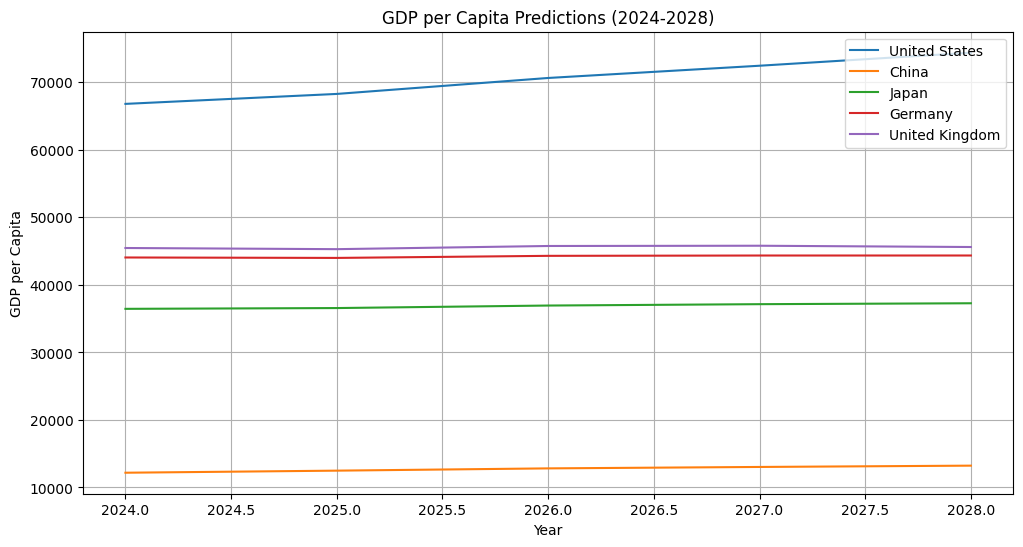


Predicted GDP per Capita (2024-2028):

United States:
2024: $66,805.87
2025: $68,280.44
2026: $70,643.18
2027: $72,456.56
2028: $74,383.15

China:
2024: $12,178.92
2025: $12,486.17
2026: $12,821.83
2027: $13,033.09
2028: $13,226.31

Japan:
2024: $36,450.59
2025: $36,566.96
2026: $36,939.71
2027: $37,141.66
2028: $37,276.76

Germany:
2024: $44,057.29
2025: $43,992.59
2026: $44,299.99
2027: $44,347.79
2028: $44,350.38

United Kingdom:
2024: $45,461.24
2025: $45,288.98
2026: $45,759.59
2027: $45,796.59
2028: $45,607.35


In [12]:
plt.figure(figsize=(12, 6))
for country in selected_countries:
    if country in predictions_by_country:
        plt.plot(range(2024, 2029), predictions_by_country[country], label=country)
plt.title('GDP per Capita Predictions (2024-2028)')
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.legend()
plt.grid(True)
plt.show()
    
    # Print predictions for selected countries
print("\nPredicted GDP per Capita (2024-2028):")
for country in selected_countries:
    if country in predictions_by_country:
        print(f"\n{country}:")
        for year, pred in zip(range(2024, 2029), predictions_by_country[country]):
            print(f"{year}: ${pred:,.2f}")

In [13]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame()
predictions_df['Country'] = predictions_by_country.keys()

# Add columns for each predicted year
for i, year in enumerate(range(2024, 2029)):
    predictions_df[str(year)] = predictions_df['Country'].map(lambda x: predictions_by_country[x][i] if x in predictions_by_country else None)

# Export to CSV
predictions_df.to_csv('gdp_predictions_2024_2028.csv', index=False)
print("\nPredictions exported to 'gdp_predictions_2024_2028.csv'")



Predictions exported to 'gdp_predictions_2024_2028.csv'
